### This notebook compares 4 runs

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

In [2]:
#get CESM1 OMIP run annual tavg files - avg over years 218 to 238
styr=218
endyr=239
case = 'GECO.IAF.20th.x1.CESM1.001'

In [3]:
files = []
for year in range(styr,endyr):
    yr4="{:04d}".format(year)
    #print('doing simulation year', year, '!')
    files.extend(sorted(glob(f'/glade/scratch/mclong/hpss-mirror/{case}/ocn/proc/tavg/annual/{case}.pop.h.{yr4}.nc')))

In [4]:
files

['/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0218.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0219.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0220.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0221.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0222.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0223.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.pop.h.0224.nc',
 '/glade/scratch/mclong/hpss-mirror/GECO.IAF.20th.x1.CESM1.001/ocn/proc/tavg/annual/GECO.IAF.20th.x1.CESM1.001.

In [5]:
ds4=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [6]:
case1 = 'g.e21.G1850ECOIAF.T62_g16.001'
case2 = 'g.e21.G1850ECOIAF.T62_g16.004'
case3 = 'g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001'
path1 = '/glade/scratch/kristenk/archive/' + case1 + '/ocn/proc/tseries/month_1'
path2 = '/glade/scratch/kristenk/archive/' + case2 + '/ocn/proc/tseries/month_1'
path3 = '/glade/collections/cdg/timeseries-cmip6/' + case3 + '/ocn/proc/tseries/month_1'

In [7]:
variables = ['NO3', 'PO4','AOU','O2','SiO3']

In [8]:
coords = {'x':'TLONG','y':'TLAT'}

In [9]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

In [10]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds4 = ds4.drop([v for v in ds4.variables if v not in keep_vars])

In [11]:
%%time

ds_list = []

print(f'reading {case1}')

ds1 = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path1}/{case1}.pop.h.{v}.??????-??????.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds1 = xr.merge((ds1, dsv))
    ds_list.append(ds1)

reading g.e21.G1850ECOIAF.T62_g16.001
NO3
PO4
AOU
O2
SiO3
CPU times: user 3.2 s, sys: 360 ms, total: 3.56 s
Wall time: 5.5 s


In [12]:
%%time

ds_list = []

print(f'reading {case2}')

ds2 = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path2}/{case2}.pop.h.{v}.??????-??????.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

reading g.e21.G1850ECOIAF.T62_g16.004
NO3
PO4
AOU
O2
SiO3
CPU times: user 3.23 s, sys: 267 ms, total: 3.5 s
Wall time: 5.36 s


In [13]:
%%time

ds_list = []

print(f'reading {case3}')

ds3 = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path3}/{case3}.pop.h.{v}.00????-??????.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds3 = xr.merge((ds3, dsv))
    ds_list.append(ds3)

reading g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001
NO3
PO4
AOU
O2
SiO3
CPU times: user 3.41 s, sys: 363 ms, total: 3.78 s
Wall time: 7.97 s


In [14]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds1 = ds1.drop([v for v in ds1.variables if v not in keep_vars])
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])
ds3 = ds3.drop([v for v in ds2.variables if v not in keep_vars])

In [15]:
ds1["time"] = ds1.time_bound.compute().mean(dim="d2")
ds2["time"] = ds2.time_bound.compute().mean(dim="d2")
ds2["time"] = ds2.time_bound.compute().mean(dim="d2")

In [16]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds1.z_t
tlen=len(ds1.time)
tlen

1488

calcs for maps

In [17]:
ds1_annmean = xr.Dataset()
ds1_annmean['NO3'] = ds1.NO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['PO4'] = ds1.PO4.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['SiO3'] = ds1.SiO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['AOU'] = ds1.AOU.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['O2'] = ds1.O2.isel(time=slice(-120,tlen)).mean(dim='time')

In [18]:
ds2_annmean = xr.Dataset()
ds2_annmean['NO3'] = ds2.NO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['PO4'] = ds2.PO4.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['SiO3'] = ds2.SiO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['AOU'] = ds2.AOU.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['O2'] = ds2.O2.isel(time=slice(-120,tlen)).mean(dim='time')

In [19]:
ds3_annmean = xr.Dataset()
ds3_annmean['NO3'] = ds3.NO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds3_annmean['PO4'] = ds3.PO4.isel(time=slice(-120,tlen)).mean(dim='time')
ds3_annmean['SiO3'] = ds3.SiO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds3_annmean['AOU'] = ds3.AOU.isel(time=slice(-120,tlen)).mean(dim='time')
ds3_annmean['O2'] = ds3.O2.isel(time=slice(-120,tlen)).mean(dim='time')

In [20]:
ds4_annmean = xr.Dataset()
ds4_annmean['NO3'] = ds4.NO3.mean(dim='time')
ds4_annmean['PO4'] = ds4.PO4.mean(dim='time')
ds4_annmean['SiO3'] = ds4.SiO3.mean(dim='time')
ds4_annmean['AOU'] = ds4.AOU.mean(dim='time')
ds4_annmean['O2'] = ds4.O2.mean(dim='time')

In [21]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT

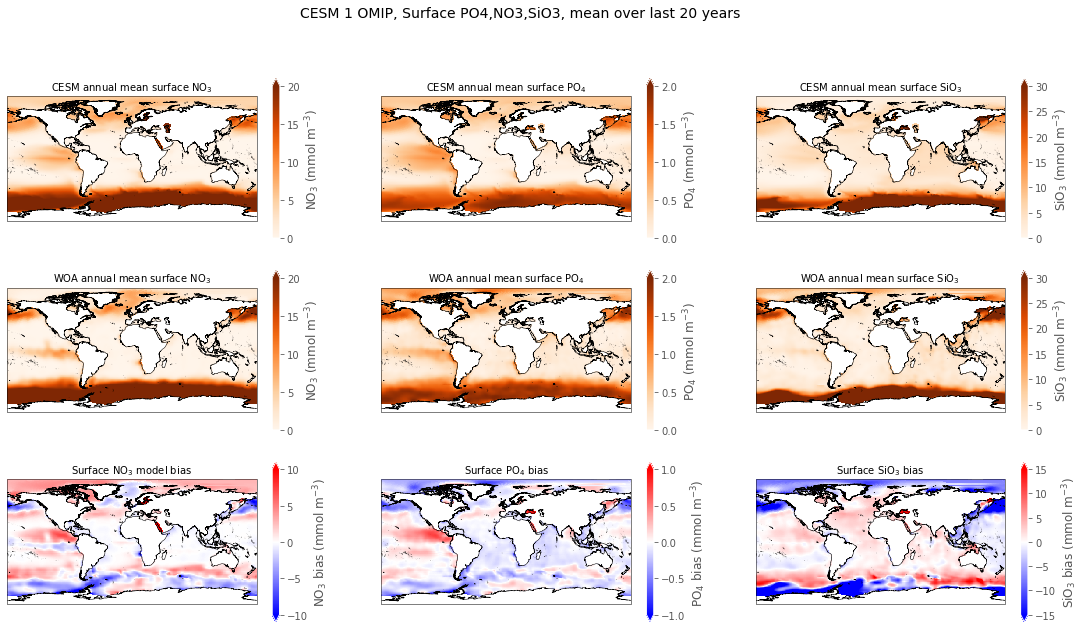

In [22]:
fig = plt.figure(figsize=(19,10))
plt.suptitle('CESM 1 OMIP, Surface PO4,NO3,SiO3, mean over last 20 years', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds4_annmean.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds4_annmean.NO3.isel(z_t=0) - ds_woa.NO3.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds4_annmean.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds4_annmean.PO4.isel(z_t=0) - ds_woa.PO4.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds4_annmean.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds4_annmean.SiO3.isel(z_t=0) - ds_woa.SiO3.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

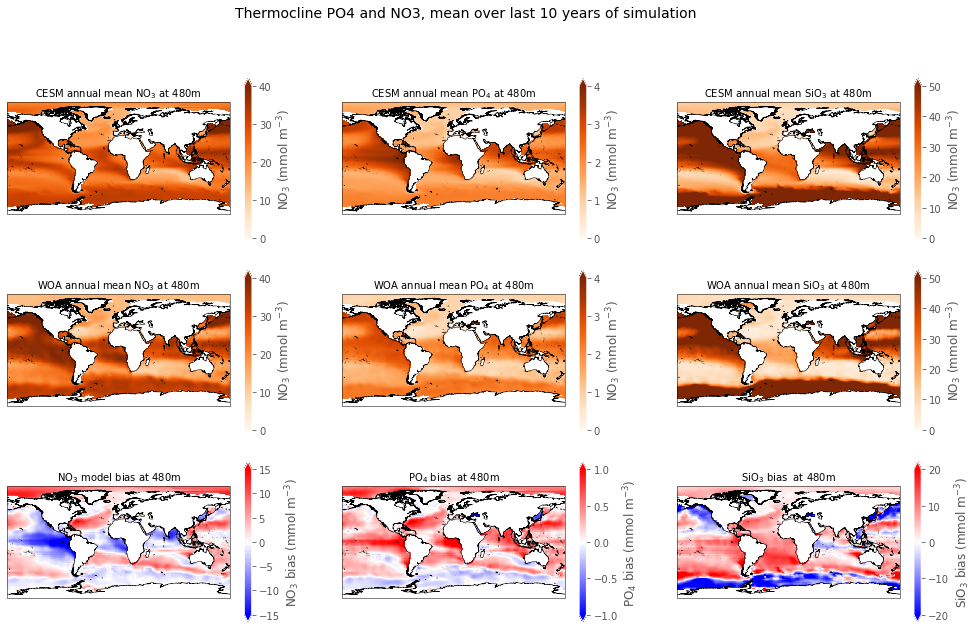

In [107]:
fig = plt.figure(figsize=(17,10))

plt.suptitle('Thermocline PO4 and NO3, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3######################

#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean NO$_3$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds4_annmean.NO3.isel(z_t=32), vmin=0, vmax=40, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean NO$_3$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=32), vmin=0, vmax=40, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('NO$_3$ model bias at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds4_annmean.NO3.isel(z_t=32) - ds_woa.NO3.isel(z_t=32), vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

#COLUMN 1  - PO4######################
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean PO$_4$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds4_annmean.PO4.isel(z_t=32), vmin=0, vmax=4, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean PO$_4$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=32), vmin=0, vmax=4, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('PO$_4$ bias  at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds4_annmean.PO4.isel(z_t=32) - ds_woa.PO4.isel(z_t=32), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



#COLUMN 3  - SiO3######################
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean SiO$_3$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds4_annmean.SiO3.isel(z_t=32), vmin=0, vmax=50, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean SiO$_3$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=32), vmin=0, vmax=50, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('SiO$_3$ bias  at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ds4_annmean.SiO3.isel(z_t=32) - ds_woa.SiO3.isel(z_t=32), vmin=-20, vmax=20, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

calcs for profiles

In [40]:
ds1_glb = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_glb['NO3']= esmlab.weighted_mean(ds1_annmean['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['PO4']= esmlab.weighted_mean(ds1_annmean['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['O2']= esmlab.weighted_mean(ds1_annmean['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['AOU']= esmlab.weighted_mean(ds1_annmean['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [41]:
ds2_glb = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds2_glb['NO3']= esmlab.weighted_mean(ds2_annmean['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['PO4']= esmlab.weighted_mean(ds2_annmean['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['O2']= esmlab.weighted_mean(ds2_annmean['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['AOU']= esmlab.weighted_mean(ds2_annmean['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [42]:
ds3_glb = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds3_glb['NO3']= esmlab.weighted_mean(ds3_annmean['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds3_glb['PO4']= esmlab.weighted_mean(ds3_annmean['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds3_glb['SiO3']= esmlab.weighted_mean(ds3_annmean['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds3_glb['O2']= esmlab.weighted_mean(ds3_annmean['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds3_glb['AOU']= esmlab.weighted_mean(ds3_annmean['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [43]:
ds4_glb = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds4_glb['NO3']= esmlab.weighted_mean(ds4_annmean['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_glb['PO4']= esmlab.weighted_mean(ds4_annmean['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_glb['SiO3']= esmlab.weighted_mean(ds4_annmean['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_glb['O2']= esmlab.weighted_mean(ds4_annmean['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_glb['AOU']= esmlab.weighted_mean(ds4_annmean['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [45]:
ds_glb_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

calcs for Southern Ocean profiles

In [22]:
ds1_SO = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound','z_t']})
ds1_SO['NO3']= esmlab.weighted_mean(ds1_annmean['NO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_SO['PO4']= esmlab.weighted_mean(ds1_annmean['PO4'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_SO['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [23]:
ds2_SO = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound','z_t']})
ds2_SO['NO3']= esmlab.weighted_mean(ds2_annmean['NO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_SO['PO4']= esmlab.weighted_mean(ds2_annmean['PO4'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_SO['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [24]:
ds3_SO = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound','z_t']})
ds3_SO['NO3']= esmlab.weighted_mean(ds3_annmean['NO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds3_SO['PO4']= esmlab.weighted_mean(ds3_annmean['PO4'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds3_SO['SiO3']= esmlab.weighted_mean(ds3_annmean['SiO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [27]:
ds4_SO = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound','z_t']})
ds4_SO['NO3']= esmlab.weighted_mean(ds4_annmean['NO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_SO['PO4']= esmlab.weighted_mean(ds4_annmean['PO4'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_SO['SiO3']= esmlab.weighted_mean(ds4_annmean['SiO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [28]:
ds_woa_SO = xr.Dataset({v: ds1[v] for v in ['z_t']})
ds_woa_SO['NO3']= esmlab.weighted_mean(ds_woa['NO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_woa_SO['PO4']= esmlab.weighted_mean(ds_woa['PO4'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_woa_SO['SiO3']= esmlab.weighted_mean(ds_woa['SiO3'].where(lats<-30), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [31]:
zero_bias=np.array([ 0., 0.])
zero_depths=np.array([ 0., 6000.])

In [32]:
depths=ds_woa.z_t * 0.01

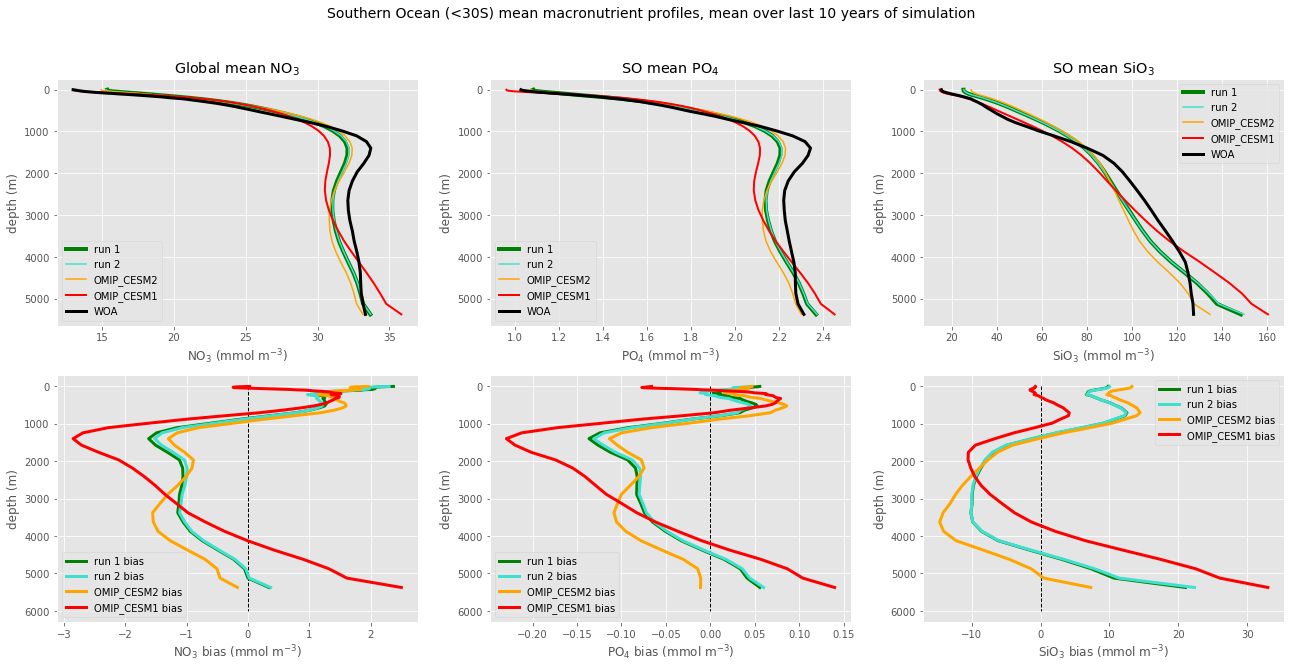

In [33]:
fig = plt.figure(figsize=(22,10))

plt.suptitle('Southern Ocean (<30S) mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)



#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds1_SO['NO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_SO['NO3'].values, depths, label='run 2', linewidth=1.5, color='turquoise')
ax.plot(ds3_SO['NO3'].values, depths, label='OMIP_CESM2', linewidth=1.5, color='orange')
ax.plot(ds4_SO['NO3'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_woa_SO['NO3'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('SO mean PO$_4$')
ax.plot(ds1_SO['PO4'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_SO['PO4'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_SO['PO4'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_SO['PO4'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_woa_SO['PO4'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('SO mean SiO$_3$')
ax.plot(ds1_SO['SiO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_SO['SiO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_SO['SiO3'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_SO['SiO3'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_woa_SO['SiO3'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()






#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_SO['NO3'].values - ds_woa_SO['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_SO['NO3'].values - ds_woa_SO['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_SO['NO3'].values - ds_woa_SO['NO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_SO['NO3'].values - ds_woa_SO['NO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_SO['PO4'].values - ds_woa_SO['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_SO['PO4'].values - ds_woa_SO['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_SO['PO4'].values - ds_woa_SO['PO4'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_SO['PO4'].values - ds_woa_SO['PO4'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_SO['SiO3'].values - ds_woa_SO['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_SO['SiO3'].values - ds_woa_SO['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_SO['SiO3'].values - ds_woa_SO['SiO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_SO['SiO3'].values - ds_woa_SO['SiO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


In [46]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

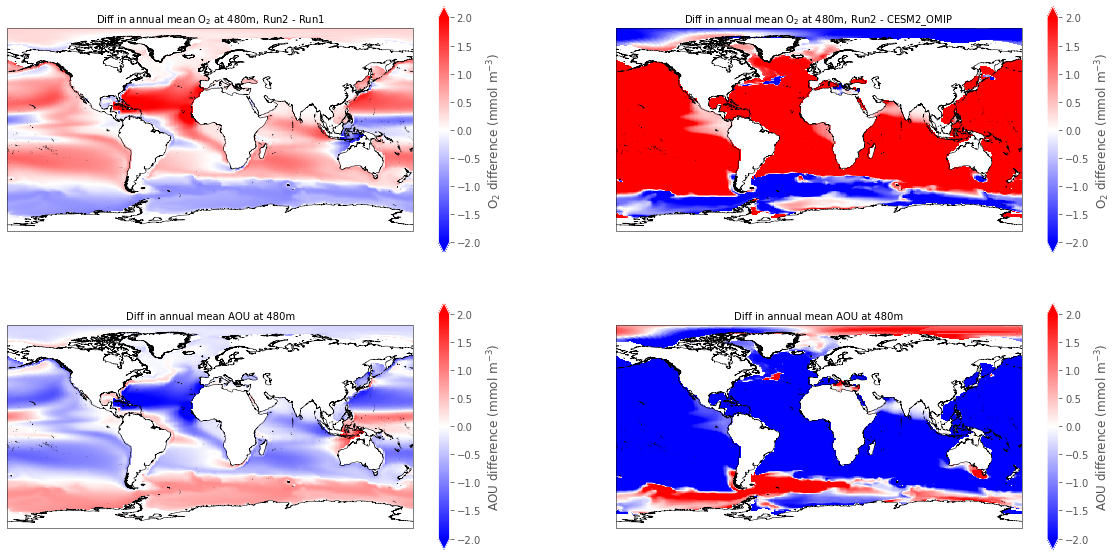

In [22]:
fig = plt.figure(figsize=(20,10))


#COLUMN 1  - O2 diff with previous run
#---- 
ax = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean O$_2$ at 480m, Run2 - Run1', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.O2.isel(z_t=32)-ds1_annmean.O2.isel(z_t=32),cmap='bwr',
                 vmin=-2, vmax=2, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='O$_2$ difference (mmol m$^{-3}$)')

#----  AOU diff
ax = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean AOU at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.AOU.isel(z_t=32)-ds1_annmean.AOU.isel(z_t=32), cmap='bwr',
                 vmin=-2, vmax=2, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='AOU difference (mmol m$^{-3}$)')


#COLUMN 1  - O2 diff OMIP
#---- 
ax = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean O$_2$ at 480m, Run2 - CESM2_OMIP', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.O2.isel(z_t=32)-ds3_annmean.O2.isel(z_t=32),cmap='bwr',
                 vmin=-2, vmax=2, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='O$_2$ difference (mmol m$^{-3}$)')

#----  AOU diff
ax = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean AOU at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.AOU.isel(z_t=32)-ds3_annmean.AOU.isel(z_t=32), cmap='bwr',
                 vmin=-2, vmax=2, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='AOU difference (mmol m$^{-3}$)')





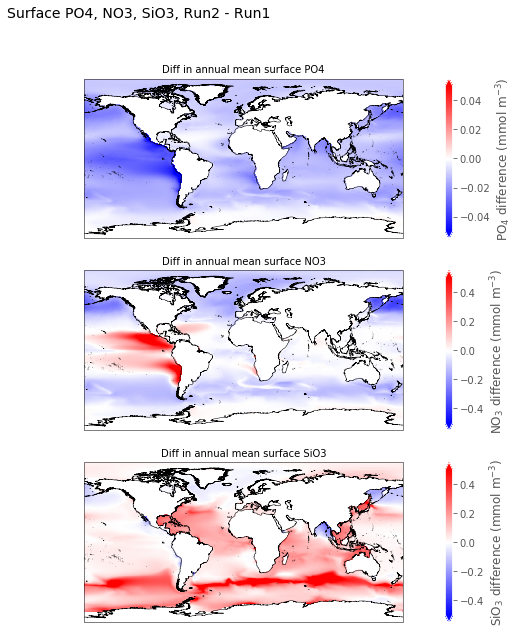

In [23]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Surface PO4, NO3, SiO3, Run2 - Run1', fontsize=14)

#COLUMN 1  - PO4 diff
#---- 
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface PO4', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.PO4.isel(z_t=0)-ds1_annmean.PO4.isel(z_t=0),cmap='bwr',
                 vmin=-0.05, vmax=0.05, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PO$_4$ difference (mmol m$^{-3}$)')

#----  NO3 diff
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface NO3', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.NO3.isel(z_t=0)-ds1_annmean.NO3.isel(z_t=0), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='NO$_3$ difference (mmol m$^{-3}$)')

#----  SiO3 diff
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface SiO3', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.SiO3.isel(z_t=0)-ds1_annmean.SiO3.isel(z_t=0), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='SiO$_3$ difference (mmol m$^{-3}$)')

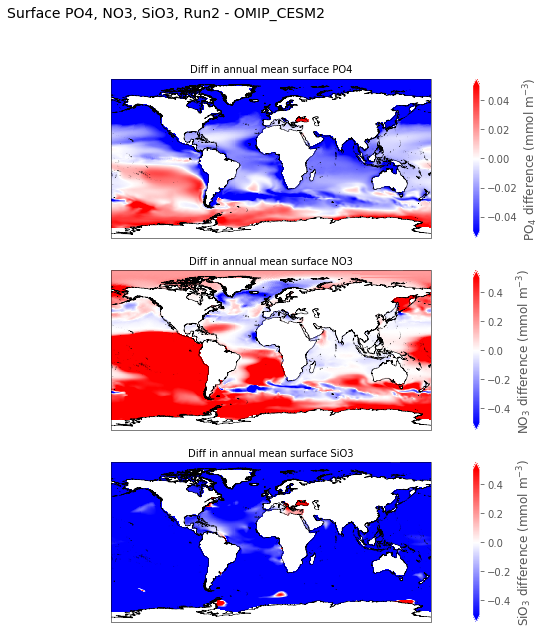

In [24]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Surface PO4, NO3, SiO3, Run2 - OMIP_CESM2', fontsize=14)

#COLUMN 1  - PO4 diff
#---- 
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface PO4', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.PO4.isel(z_t=0)-ds3_annmean.PO4.isel(z_t=0),cmap='bwr',
                 vmin=-0.05, vmax=0.05, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PO$_4$ difference (mmol m$^{-3}$)')

#----  NO3 diff
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface NO3', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.NO3.isel(z_t=0)-ds3_annmean.NO3.isel(z_t=0), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='NO$_3$ difference (mmol m$^{-3}$)')

#----  SiO3 diff
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface SiO3', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.SiO3.isel(z_t=0)-ds3_annmean.SiO3.isel(z_t=0), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='SiO$_3$ difference (mmol m$^{-3}$)')

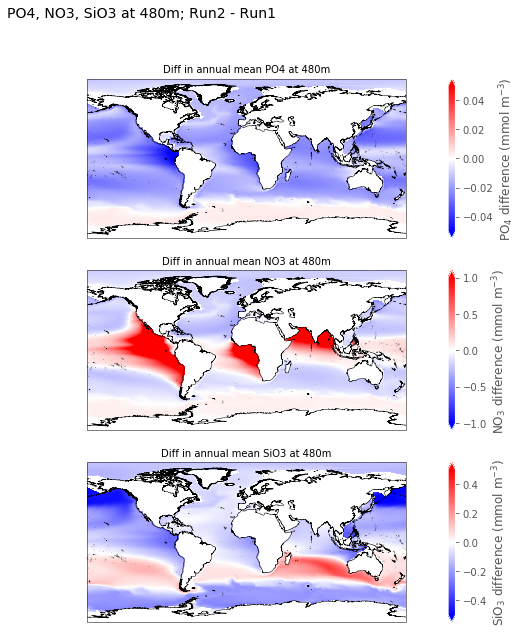

In [25]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('PO4, NO3, SiO3 at 480m; Run2 - Run1', fontsize=14)

#COLUMN 1  - PO4 diff
#---- 
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean PO4 at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.PO4.isel(z_t=32)-ds1_annmean.PO4.isel(z_t=32),cmap='bwr',
                 vmin=-0.05, vmax=0.05, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PO$_4$ difference (mmol m$^{-3}$)')

#----  NO3 diff
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean NO3 at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.NO3.isel(z_t=32)-ds1_annmean.NO3.isel(z_t=32), cmap='bwr',
                 vmin=-1, vmax=1, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='NO$_3$ difference (mmol m$^{-3}$)')

#----  SiO3 diff
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean SiO3 at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.SiO3.isel(z_t=32)-ds1_annmean.SiO3.isel(z_t=32), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='SiO$_3$ difference (mmol m$^{-3}$)')

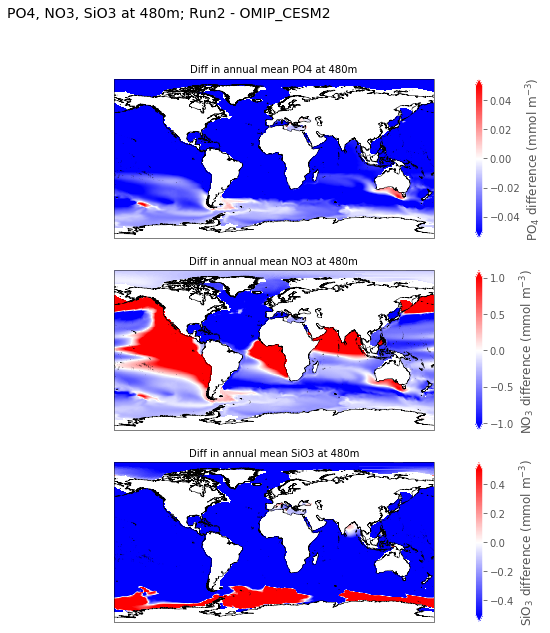

In [26]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('PO4, NO3, SiO3 at 480m; Run2 - OMIP_CESM2', fontsize=14)

#COLUMN 1  - PO4 diff
#---- 
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean PO4 at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.PO4.isel(z_t=32)-ds3_annmean.PO4.isel(z_t=32),cmap='bwr',
                 vmin=-0.05, vmax=0.05, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PO$_4$ difference (mmol m$^{-3}$)')

#----  NO3 diff
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean NO3 at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.NO3.isel(z_t=32)-ds3_annmean.NO3.isel(z_t=32), cmap='bwr',
                 vmin=-1, vmax=1, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='NO$_3$ difference (mmol m$^{-3}$)')

#----  SiO3 diff
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean SiO3 at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.SiO3.isel(z_t=32)-ds3_annmean.SiO3.isel(z_t=32), cmap='bwr',
                 #vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='SiO$_3$ difference (mmol m$^{-3}$)')

In [86]:
zero_bias=np.array([ 0., 0.])
zero_depths=np.array([ 0., 6000.])

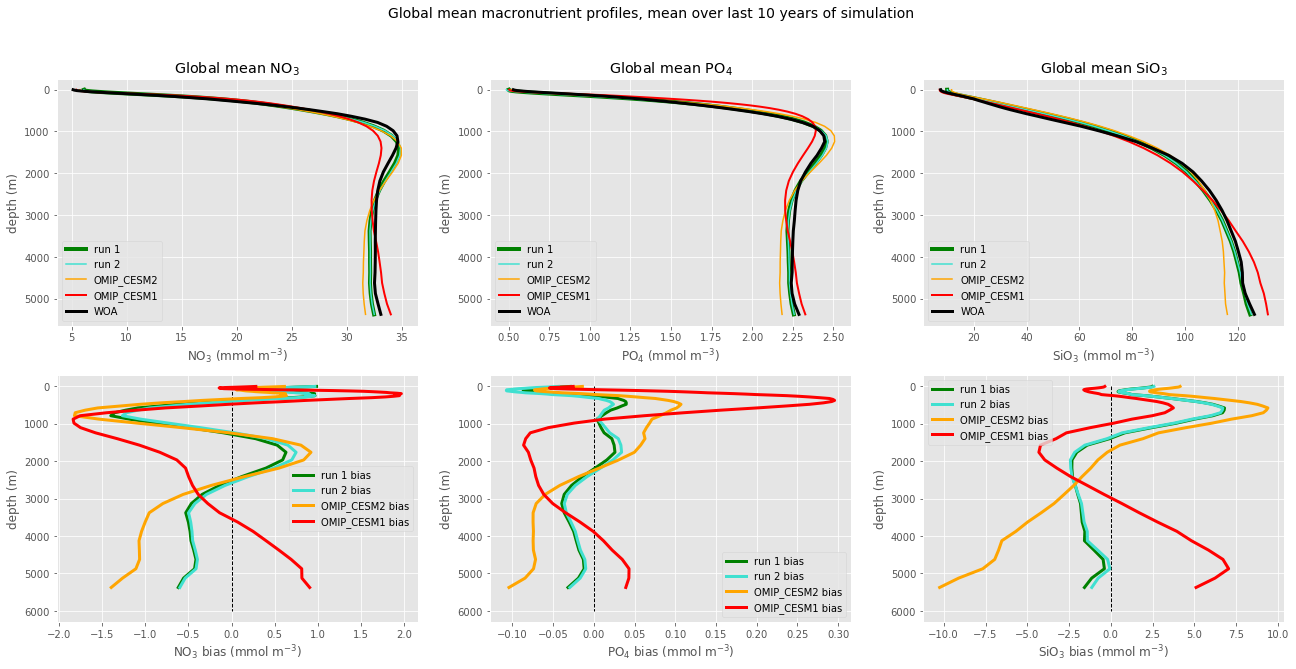

In [90]:
fig = plt.figure(figsize=(22,10))

plt.suptitle('Global mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds1_glb['NO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_glb['NO3'].values, depths, label='run 2', linewidth=1.5, color='turquoise')
ax.plot(ds3_glb['NO3'].values, depths, label='OMIP_CESM2', linewidth=1.5, color='orange')
ax.plot(ds4_glb['NO3'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds1_glb['PO4'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_glb['PO4'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_glb['PO4'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_glb['PO4'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds1_glb['SiO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_glb['SiO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_glb['SiO3'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_glb['SiO3'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()






#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



by major basin

In [49]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

Pacific

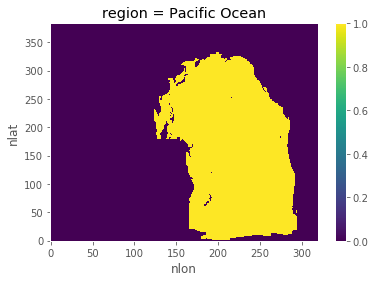

In [50]:
regnum=2
mask3d.isel(region=regnum).plot();

In [51]:
ds1_pac = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_pac['NO3']= esmlab.weighted_mean(ds1_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['PO4']= esmlab.weighted_mean(ds1_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['O2']= esmlab.weighted_mean(ds1_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['AOU']= esmlab.weighted_mean(ds1_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [52]:
ds2_pac = xr.Dataset({v: ds2[v] for v in ['time', 'time_bound']})
ds2_pac['NO3']= esmlab.weighted_mean(ds2_annmean['NO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['PO4']= esmlab.weighted_mean(ds2_annmean['PO4']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['O2']= esmlab.weighted_mean(ds2_annmean['O2']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['AOU']= esmlab.weighted_mean(ds2_annmean['AOU']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()

In [53]:
ds3_pac = xr.Dataset({v: ds3[v] for v in ['time', 'time_bound']})
ds3_pac['NO3']= esmlab.weighted_mean(ds3_annmean['NO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_pac['PO4']= esmlab.weighted_mean(ds3_annmean['PO4']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_pac['SiO3']= esmlab.weighted_mean(ds3_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_pac['O2']= esmlab.weighted_mean(ds3_annmean['O2']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_pac['AOU']= esmlab.weighted_mean(ds3_annmean['AOU']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()

In [60]:
ds4_pac = xr.Dataset()
ds4_pac['NO3']= esmlab.weighted_mean(ds4_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_pac['PO4']= esmlab.weighted_mean(ds4_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_pac['SiO3']= esmlab.weighted_mean(ds4_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_pac['O2']= esmlab.weighted_mean(ds4_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds4_pac['AOU']= esmlab.weighted_mean(ds4_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [55]:
ds_pac_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_pac_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [61]:
ds4_pac

<xarray.Dataset>
Dimensions:  (z_t: 60)
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
    region   <U14 'Pacific Ocean'
Data variables:
    NO3      (z_t) float64 2.512 2.518 2.561 2.702 ... 20.18 20.9 22.55 25.07
    PO4      (z_t) float64 0.269 0.2694 0.2724 0.2828 ... 1.387 1.437 1.55 1.724
    SiO3     (z_t) float64 2.617 2.621 2.651 2.729 ... 82.51 85.24 91.43 101.8
    O2       (z_t) float64 117.0 117.0 117.2 118.1 ... 100.5 105.4 113.1 121.2
    AOU      (z_t) float64 0.1308 0.1586 0.2859 0.8075 ... 101.2 109.5 123.5

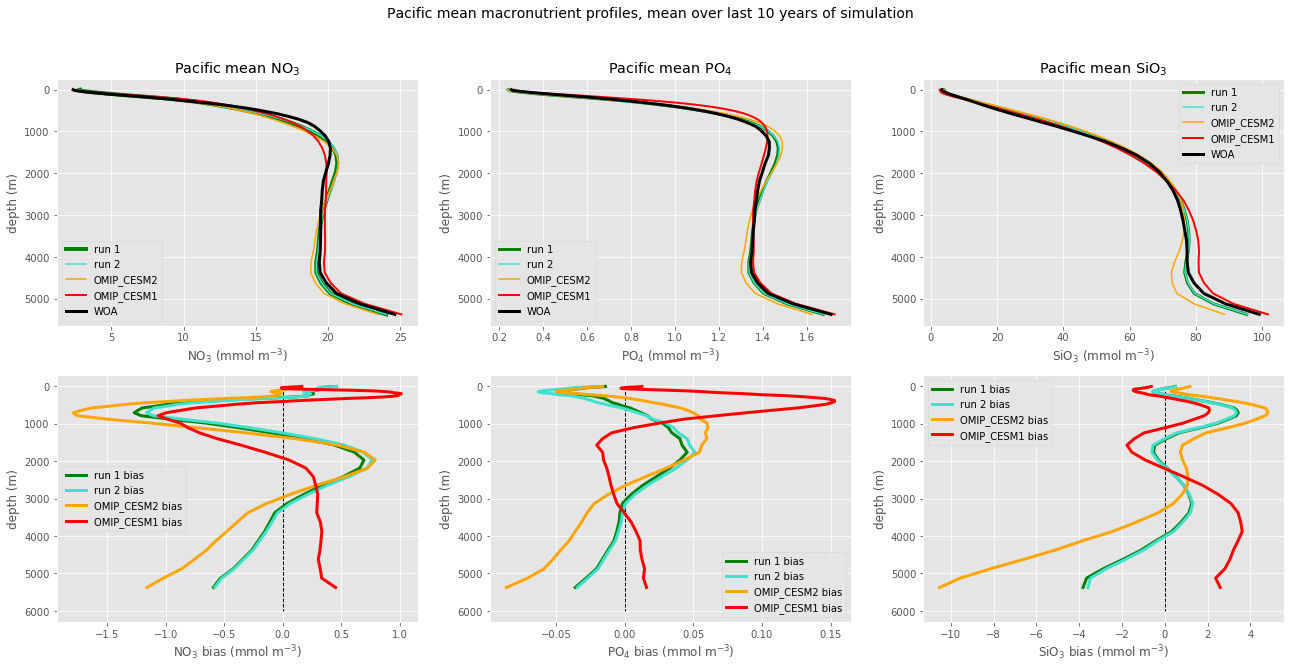

In [91]:
fig = plt.figure(figsize=(22,10))

plt.suptitle('Pacific mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific mean NO$_3$')
ax.plot(ds1_pac['NO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_pac['NO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_pac['NO3'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_pac['NO3'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_pac_woa['NO3'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Pacific mean PO$_4$')
ax.plot(ds1_pac['PO4'].values, depths, label='run 1', linewidth=3,color='green')
ax.plot(ds2_pac['PO4'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_pac['PO4'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_pac['PO4'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_pac_woa['PO4'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Pacific mean SiO$_3$')
ax.plot(ds1_pac['SiO3'].values, depths, label='run 1', linewidth=3,color='green')
ax.plot(ds2_pac['SiO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_pac['SiO3'].values, depths, label='OMIP_CESM2', linewidth=1.5,color='orange')
ax.plot(ds4_pac['SiO3'].values, depths, label='OMIP_CESM1', linewidth=2, color='red')
ax.plot(ds_pac_woa['SiO3'].values, depths, label='WOA', linewidth=3, color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')

ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



Atlantic

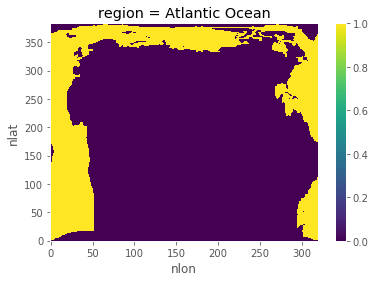

In [65]:
regnum=1
mask3d.isel(region=regnum).plot();

In [66]:
ds1_atl = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_atl['NO3']= esmlab.weighted_mean(ds1_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['PO4']= esmlab.weighted_mean(ds1_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['O2']= esmlab.weighted_mean(ds1_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['AOU']= esmlab.weighted_mean(ds1_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [67]:
ds2_atl = xr.Dataset({v: ds2[v] for v in ['time', 'time_bound']})
ds2_atl['NO3']= esmlab.weighted_mean(ds2_annmean['NO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['PO4']= esmlab.weighted_mean(ds2_annmean['PO4']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['O2']= esmlab.weighted_mean(ds2_annmean['O2']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['AOU']= esmlab.weighted_mean(ds2_annmean['AOU']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()

In [68]:
ds3_atl = xr.Dataset({v: ds3[v] for v in ['time', 'time_bound']})
ds3_atl['NO3']= esmlab.weighted_mean(ds3_annmean['NO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_atl['PO4']= esmlab.weighted_mean(ds3_annmean['PO4']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_atl['SiO3']= esmlab.weighted_mean(ds3_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_atl['O2']= esmlab.weighted_mean(ds3_annmean['O2']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_atl['AOU']= esmlab.weighted_mean(ds3_annmean['AOU']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()

In [69]:
ds4_atl = xr.Dataset({v: ds3[v] for v in ['time', 'time_bound']})
ds4_atl['NO3']= esmlab.weighted_mean(ds4_annmean['NO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_atl['PO4']= esmlab.weighted_mean(ds4_annmean['PO4']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_atl['SiO3']= esmlab.weighted_mean(ds4_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_atl['O2']= esmlab.weighted_mean(ds4_annmean['O2']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_atl['AOU']= esmlab.weighted_mean(ds4_annmean['AOU']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()

In [70]:
ds_atl_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_atl_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

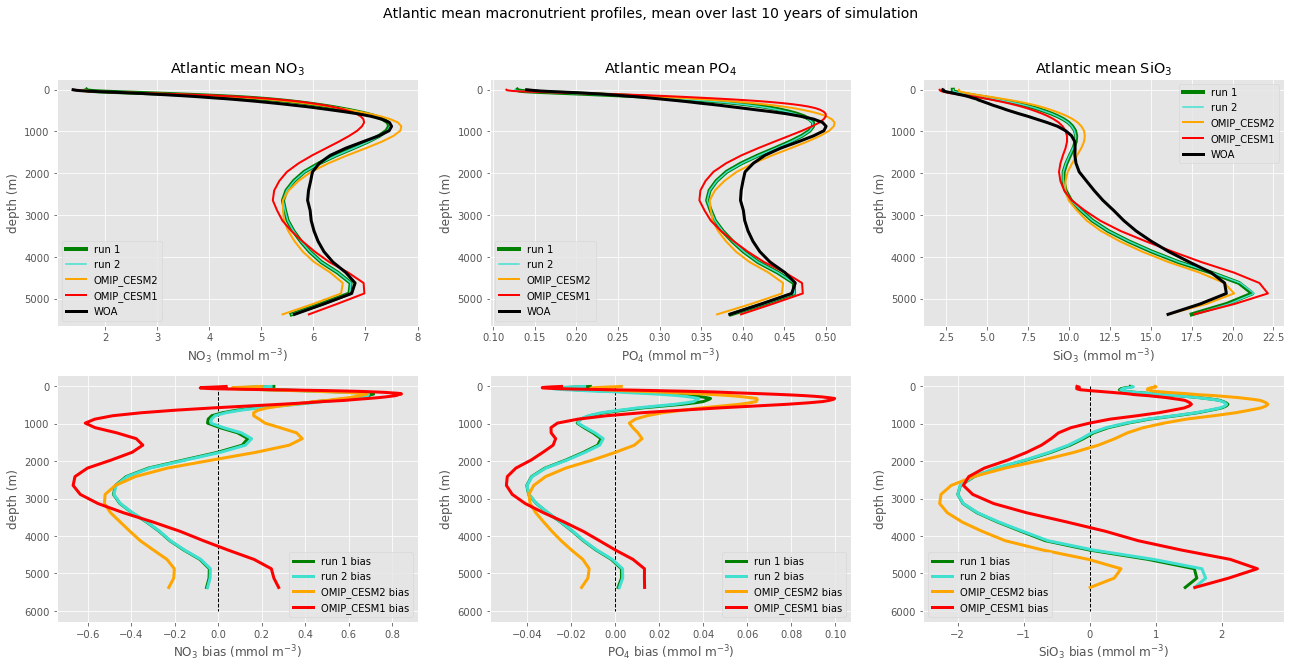

In [92]:
fig = plt.figure(figsize=(22,10))

plt.suptitle('Atlantic mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Atlantic mean NO$_3$')
ax.plot(ds1_atl['NO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_atl['NO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_atl['NO3'].values, depths, label='OMIP_CESM2', linewidth=2,color='orange')
ax.plot(ds4_atl['NO3'].values, depths, label='OMIP_CESM1', linewidth=2,color='red')
ax.plot(ds_atl_woa['NO3'].values, depths, label='WOA', linewidth=3,color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Atlantic mean PO$_4$')
ax.plot(ds1_atl['PO4'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_atl['PO4'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_atl['PO4'].values, depths, label='OMIP_CESM2', linewidth=2,color='orange')
ax.plot(ds4_atl['PO4'].values, depths, label='OMIP_CESM1', linewidth=2,color='red')
ax.plot(ds_atl_woa['PO4'].values, depths, label='WOA', linewidth=3,color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic mean SiO$_3$')
ax.plot(ds1_atl['SiO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_atl['SiO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_atl['SiO3'].values, depths, label='OMIP_CESM2', linewidth=2,color='orange')
ax.plot(ds4_atl['SiO3'].values, depths, label='OMIP_CESM1', linewidth=2,color='red')
ax.plot(ds_atl_woa['SiO3'].values, depths, label='WOA', linewidth=3,color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



Indian

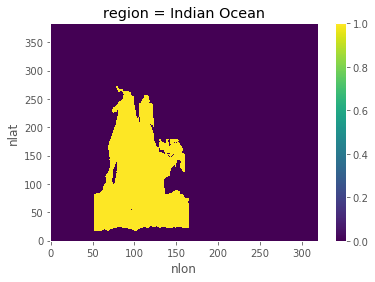

In [73]:
regnum=3
mask3d.isel(region=regnum).plot();

In [74]:
ds1_ind = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_ind['NO3']= esmlab.weighted_mean(ds1_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['PO4']= esmlab.weighted_mean(ds1_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['O2']= esmlab.weighted_mean(ds1_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['AOU']= esmlab.weighted_mean(ds1_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [75]:
ds2_ind = xr.Dataset({v: ds2[v] for v in ['time', 'time_bound']})
ds2_ind['NO3']= esmlab.weighted_mean(ds2_annmean['NO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['PO4']= esmlab.weighted_mean(ds2_annmean['PO4']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['O2']= esmlab.weighted_mean(ds2_annmean['O2']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['AOU']= esmlab.weighted_mean(ds2_annmean['AOU']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()

In [76]:
ds3_ind = xr.Dataset({v: ds3[v] for v in ['time', 'time_bound']})
ds3_ind['NO3']= esmlab.weighted_mean(ds3_annmean['NO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_ind['PO4']= esmlab.weighted_mean(ds3_annmean['PO4']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_ind['SiO3']= esmlab.weighted_mean(ds3_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_ind['O2']= esmlab.weighted_mean(ds3_annmean['O2']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds3_ind['AOU']= esmlab.weighted_mean(ds3_annmean['AOU']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()

In [77]:
ds4_ind = xr.Dataset({v: ds3[v] for v in ['time', 'time_bound']})
ds4_ind['NO3']= esmlab.weighted_mean(ds4_annmean['NO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_ind['PO4']= esmlab.weighted_mean(ds4_annmean['PO4']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_ind['SiO3']= esmlab.weighted_mean(ds4_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_ind['O2']= esmlab.weighted_mean(ds4_annmean['O2']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()
ds4_ind['AOU']= esmlab.weighted_mean(ds4_annmean['AOU']*mask3d.isel(region=regnum), weights=ds3.TAREA, dim=['nlat', 'nlon']).compute()

In [78]:
ds_ind_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_ind_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

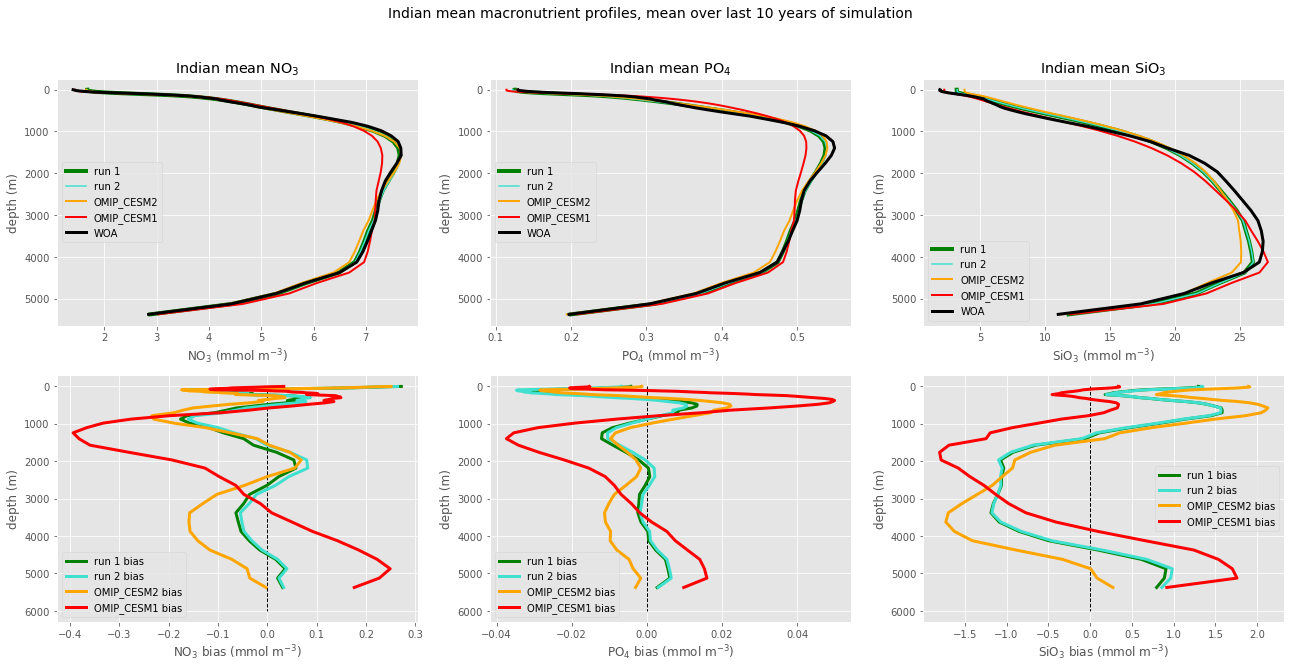

In [94]:
fig = plt.figure(figsize=(22,10))

plt.suptitle('Indian mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Indian mean NO$_3$')
ax.plot(ds1_ind['NO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_ind['NO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_ind['NO3'].values, depths, label='OMIP_CESM2', linewidth=2,color='orange')
ax.plot(ds4_ind['NO3'].values, depths, label='OMIP_CESM1', linewidth=2,color='red')
ax.plot(ds_ind_woa['NO3'].values, depths, label='WOA', linewidth=3,color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Indian mean PO$_4$')
ax.plot(ds1_ind['PO4'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_ind['PO4'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_ind['PO4'].values, depths, label='OMIP_CESM2', linewidth=2,color='orange')
ax.plot(ds4_ind['PO4'].values, depths, label='OMIP_CESM1', linewidth=2,color='red')
ax.plot(ds_ind_woa['PO4'].values, depths, label='WOA', linewidth=3,color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Indian mean SiO$_3$')
ax.plot(ds1_ind['SiO3'].values, depths, label='run 1', linewidth=4,color='green')
ax.plot(ds2_ind['SiO3'].values, depths, label='run 2', linewidth=1.5,color='turquoise')
ax.plot(ds3_ind['SiO3'].values, depths, label='OMIP_CESM2', linewidth=2,color='orange')
ax.plot(ds4_ind['SiO3'].values, depths, label='OMIP_CESM1', linewidth=2,color='red')
ax.plot(ds_ind_woa['SiO3'].values, depths, label='WOA', linewidth=3,color='black')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_ind['NO3'].values - ds_ind_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_ind['NO3'].values - ds_ind_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_ind['NO3'].values - ds_ind_woa['NO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_ind['NO3'].values - ds_ind_woa['NO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_ind['PO4'].values - ds_ind_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_ind['PO4'].values - ds_ind_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_ind['PO4'].values - ds_ind_woa['PO4'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_ind['PO4'].values - ds_ind_woa['PO4'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(zero_bias, zero_depths,'--', linewidth=1,color='black')
ax.plot(ds1_ind['SiO3'].values - ds_ind_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_ind['SiO3'].values - ds_ind_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.plot(ds3_ind['SiO3'].values - ds_ind_woa['SiO3'].values, depths, label='OMIP_CESM2 bias', linewidth=3, color='orange')
ax.plot(ds4_ind['SiO3'].values - ds_ind_woa['SiO3'].values, depths, label='OMIP_CESM1 bias', linewidth=3, color='red')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

